#Pneumonia Prediction from Chest X-Ray Images of Pediatric Patients Using Deep Learning
Name: Imran Chowdhury Dipto <br> ID: 21420004

In [ ]:
# Importing important libraries
import numpy as np
import pandas as pd
import tensorflow as tf 
from numpy.random import seed
seed(1)
tf.random.set_seed(1)
from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_recall_curve, roc_curve, auc, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import seaborn as sns 
import os 
import cv2
import glob
sns.set_style("whitegrid")                                          

In [ ]:
# Loading the dataset from google drive
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Exploratory Data Analysis

In [ ]:
# setting up a few important parameters which are found optimal after a number of iterations and 
# are used throughout the experiment which are found optimal after a number of iterations
lr = 1e-4
BATCH_SIZE = 32
EPOCHS = 100
early_stop = EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True)
adam = Adam(learning_rate=lr)

# These are for barplot to show the results
model_names = []
model_scores = []

In [ ]:
# Some functions and lists for visualising the model outputs

# Function for plotting the Precision Recall curves
def plot_precision_recall(precisions, recalls, thresholds):
    plt.figure(figsize=(12, 8))
    plt.plot(thresholds, precisions[:-1])
    plt.plot(thresholds, recalls[:-1])
    plt.xlabel('Thresholds')
    plt.legend(['Precision', 'Recall'], loc='best')
    plt.show()

# Functin to plot the ROC-AUC 
def plot_roc(fpr, tpr, area):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr,tpr,label="AUC="+str(area))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.legend(loc=4)
    plt.show()

# Function to obtain the Classification report, Sensitivity, Specificity and Confusion Matrix plots
def cnf_plot(predictions):
  print(classification_report(y_test,predictions))     
  
  matrix = confusion_matrix(y_test,predictions)
  sensitivity = matrix[0,0]/(matrix[0,0]+matrix[0,1])
  sensitivity = sensitivity*100
  print('Sensitivity : ', np.round(sensitivity,2))

  specificity = matrix[1,1]/(matrix[1,0]+matrix[1,1])
  specificity = np.round(specificity*100,2)
  print('Specificity : ', specificity)

  plt.figure(figsize=(8, 6))
  ax= plt.subplot()
  sns.heatmap(matrix, annot=True, ax = ax, fmt='g')

  # labels, title and ticks
  ax.set_xlabel('Predicted Labels')
  ax.set_ylabel('True Labels') 
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

# Function to display the values of the model accuracies on top of the bars
def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.2f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.2f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

In [ ]:
# Accessing the images for Analysis

train = "/content/drive/MyDrive/chest_x_ray_dataset/chest_xray/chest_xray/train"
test = "/content/drive/MyDrive/chest_x_ray_dataset/chest_xray/chest_xray/test"
val = "/content/drive/MyDrive/chest_x_ray_dataset/chest_xray/chest_xray/val"

# Data Inspection
print("Images of PNEUMONIA and NORMAL in the Train set:\n")

num_pneumonia = len(os.listdir(os.path.join(train, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train, 'NORMAL')))
print(f"PNEUMONIA={num_pneumonia}")
print(f"NORMAL={num_normal}")
total_train = num_pneumonia + num_normal
print("Total=",total_train,"\n")

print("Images of PNEUMONIA and NORMAL in the Test set:\n")
num_pneumonia_test = len(os.listdir(os.path.join(test, 'PNEUMONIA')))
num_normal_test = len(os.listdir(os.path.join(test, 'NORMAL')))
print(f"PNEUMONIA={num_pneumonia_test}")
print(f"NORMAL={num_normal_test}")
total_test = num_pneumonia_test + num_normal_test
print("Total=",total_test,'\n')

print("Images of PNEUMONIA and NORMAL in the Validation set:\n")
num_pneumonia_val = len(os.listdir(os.path.join(val, 'PNEUMONIA')))
num_normal_val = len(os.listdir(os.path.join(val, 'NORMAL')))
print(f"PNEUMONIA={num_pneumonia_val}")
print(f"NORMAL={num_normal_val}")
total_val = num_pneumonia_val + num_normal_val
print("Total=",total_val,'\n')

print("Total Images in the entire dataset:",total_train+total_test+total_val)

# Creading seperate directories of Pneumonia and Normal which will help us to plot the data to show the class distribution
pneumonia = os.listdir("/content/drive/MyDrive/chest_x_ray_dataset/chest_xray/chest_xray/train/PNEUMONIA")
pneumonia_dir = "/content/drive/MyDrive/chest_x_ray_dataset/chest_xray/chest_xray/train/PNEUMONIA"

normal = os.listdir("/content/drive/MyDrive/chest_x_ray_dataset/chest_xray/chest_xray/train/NORMAL")
normal_dir = "/content/drive/MyDrive/chest_x_ray_dataset/chest_xray/chest_xray/train/NORMAL"

Images of PNEUMONIA and NORMAL in the Train set:

PNEUMONIA=3882
NORMAL=1342
Total= 5224 

Images of PNEUMONIA and NORMAL in the Test set:

PNEUMONIA=390
NORMAL=234
Total= 624 

Images of PNEUMONIA and NORMAL in the Validation set:

PNEUMONIA=9
NORMAL=9
Total= 18 

Total Images in the entire dataset: 5866


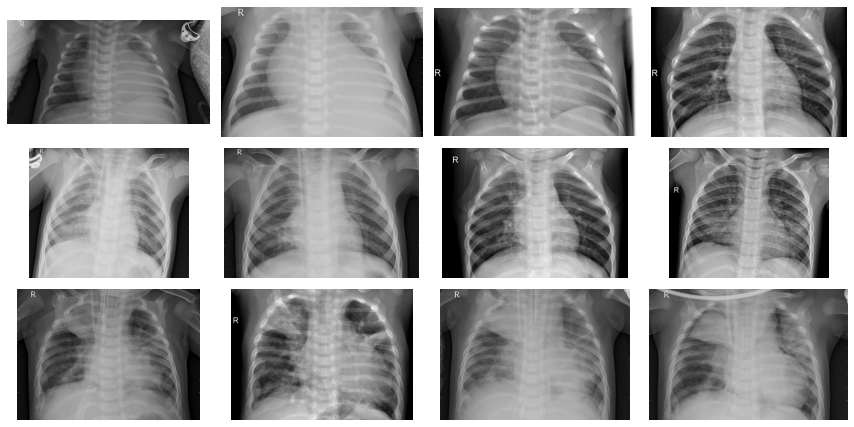

In [ ]:
# Visualising some of the images with PNEUMONIA
plt.figure(figsize=(12, 8))
for i in range(12):
    plt.subplot(4, 4, i + 1)
    img = plt.imread(os.path.join(pneumonia_dir, pneumonia[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.tight_layout()

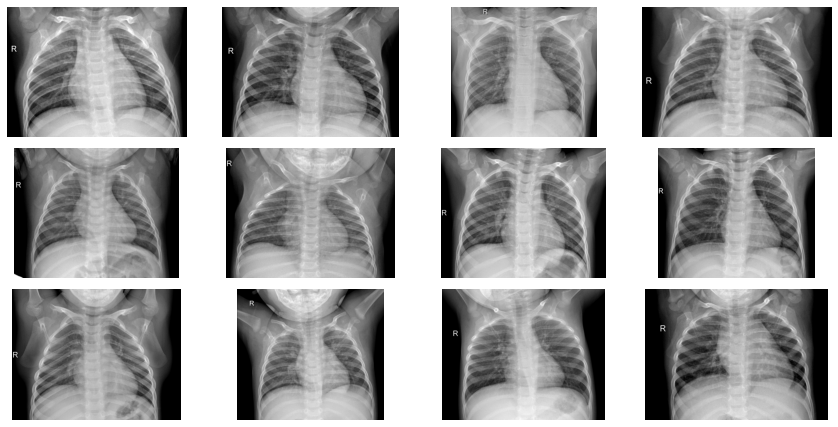

In [ ]:
# Displaying some NORMAL images
plt.figure(figsize=(12, 8))

for i in range(12):
    plt.subplot(4, 4, i + 1)
    img = plt.imread(os.path.join(normal_dir, normal[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.tight_layout()

(-1.1237263151654342,
 1.1818524766206269,
 -1.1229581414189183,
 1.173572243114488)

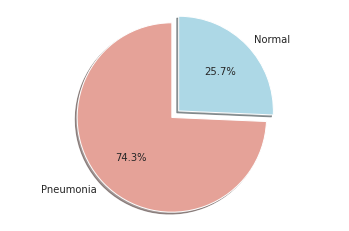

In [ ]:
# Creating a dataframe to store classes which will help our models learn from the data
# for this task the 0 = 'NORMAL' and 1 = 'PNEUMONIA'
pneumonia_train = glob.glob(train+"/PNEUMONIA/*.jpeg")
normal_train = glob.glob(train+"/NORMAL/*.jpeg")
data = pd.DataFrame(np.concatenate([[0]*len(normal_train), [1]*len(pneumonia_train)]),columns=["class"])

# Analysing the class distribution of normal and sick patients
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Pneumonia', 'Normal'
s1 = (data['class']==1).sum()
s2 = (data['class']==0).sum()
sizes = [s1,s2]
explode = (0, 0.1)

ccolors = ['#E5A298','lightblue']

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, colors=ccolors, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

#Preparing the Data

In [ ]:
# Accessing the images for training, testing and validation using OpenCV
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
      
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)
    
train = get_training_data(train)
test = get_training_data(test)
val = get_training_data(val)

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



In [ ]:
# Taking the data into numpy arrays of X and y variables
X = []
y = []

for feature, label in train:
    X.append(feature)
    y.append(label)

for feature, label in test:
    X.append(feature)
    y.append(label)
    
for feature, label in val:
    X.append(feature)
    y.append(label)

# resize data for deep learning as models expect a third dimension so I am adding 3 as DL models accept images in RGB format
X = np.array(X).reshape(-1, img_size, img_size, 3)
y = np.array(y)
X.shape, y.shape

((5862, 150, 150, 3), (5862,))

In [ ]:
# Splitting the data into training and testing size
# the test size of the data is taken as 25% of X and the remainder for training
# for validation 50% of the test size is taken

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5,random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_val.shape, y_val.shape)

(4396, 150, 150, 3) (733, 150, 150, 3) (4396,) (733,) (733, 150, 150, 3) (733,)


In [ ]:
# Scaling the data
X_train = X_train / 255.
X_test = X_test / 255.
X_val = X_val / 255.
print(X_train.shape, X_test.shape, X_val.shape)

(4396, 150, 150, 3) (733, 150, 150, 3) (733, 150, 150, 3)


In [ ]:
# Augmenting the data for deep learning as it will generate more data for the models to learn from
train_datagen = ImageDataGenerator(
        featurewise_center=False, 
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=90, 
        zoom_range = 0.1, 
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=True
)  

train_datagen.fit(X_train)
train_datagen.fit(X_test)
train_datagen.fit(X_val)
print(X_train.shape)
print(X_test.shape)

(4396, 150, 150, 3)
(733, 150, 150, 3)


##Building, Training and Testing the Baseline CNN Model

In [ ]:
#The designed CNN model
base = Sequential([
    # 1st Conv Block
    Conv2D(16, kernel_size=(3, 3), activation='relu',input_shape=(150,150,3),padding='same'),
    Conv2D(16, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2),padding='same'),

    # 2nd Conv Block
    Conv2D(32, kernel_size=(3, 3), activation='relu',input_shape=(150,150,3),padding='same'),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2),padding='same'),

    # 3rd Conv Block
    Conv2D(64, kernel_size=(3, 3), activation='relu',input_shape=(150,150,3),padding='same'),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2),padding='same'),

    # 4th Conv Block
    Conv2D(128, kernel_size=(3, 3), activation='relu',input_shape=(150,150,3),padding='same'),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2),padding='same'),
    Dropout(0.2),

    # 5th Conv Block
    Conv2D(256, kernel_size=(3, 3), activation='relu',input_shape=(150,150,3),padding='same'),
    Conv2D(256, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2),padding='same'),
    Dropout(0.2),

    # Fully connected layer
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.7),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),

    # Output Layer
    Dense(1, activation='sigmoid')
])

In [ ]:
# Compiling the model
base.compile(loss='binary_crossentropy',optimizer=adam,metrics=['acc'])
base.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 148, 148, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 74, 74, 32)        4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 batch_normalization (BatchN  (None, 72, 72, 32)       128       
 ormalization)                                          

In [ ]:
# Fit Model
history = base.fit(train_datagen.flow(X_train, y_train), 
                   callbacks=[early_stop],
                   validation_data=(X_val, y_val), 
                   epochs=EPOCHS)

Epoch 1/100
138/138 [==============================] - 27s 172ms/step - loss: 0.8573 - acc: 0.6895 - val_loss: 1.0933 - val_acc: 0.7285
Epoch 2/100
138/138 [==============================] - 23s 166ms/step - loss: 0.5020 - acc: 0.7862 - val_loss: 2.1483 - val_acc: 0.7285
Epoch 3/100
138/138 [==============================] - 23s 168ms/step - loss: 0.4370 - acc: 0.8064 - val_loss: 2.6489 - val_acc: 0.7285
Epoch 4/100
138/138 [==============================] - 23s 167ms/step - loss: 0.4081 - acc: 0.8255 - val_loss: 1.7789 - val_acc: 0.7285
Epoch 5/100
138/138 [==============================] - 23s 168ms/step - loss: 0.3790 - acc: 0.8294 - val_loss: 0.5013 - val_acc: 0.7708
Epoch 6/100
138/138 [==============================] - 23s 168ms/step - loss: 0.3617 - acc: 0.8344 - val_loss: 0.2992 - val_acc: 0.8704
Epoch 7/100
138/138 [==============================] - 23s 170ms/step - loss: 0.3437 - acc: 0.8483 - val_loss: 0.2455 - val_acc: 0.9181
Epoch 8/100
138/138 [===========================

In [ ]:
#Model evaluation
cnn_score = base.evaluate(X_test, y_test)
cnn_acc = np.round((cnn_score[1]*100),2)
print("Test Loss: ", cnn_score[0])
print("Test Accuracy: ", cnn_acc)

model_names.append("CNN")
model_scores.append(cnn_acc)

23/23 [==============================] - 0s 10ms/step - loss: 0.1435 - acc: 0.9577
Test Loss:  0.1435413807630539
Test Accuracy:  95.77


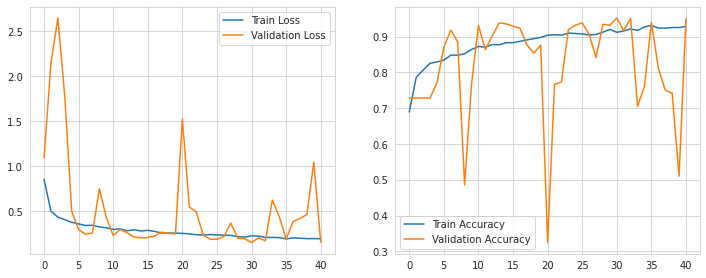

In [ ]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(history.history['acc'], label='Train Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.legend()

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       525
           1       0.94      0.91      0.92       208

    accuracy                           0.96       733
   macro avg       0.95      0.94      0.95       733
weighted avg       0.96      0.96      0.96       733

Sensitivity :  97.52
Specificity :  91.35


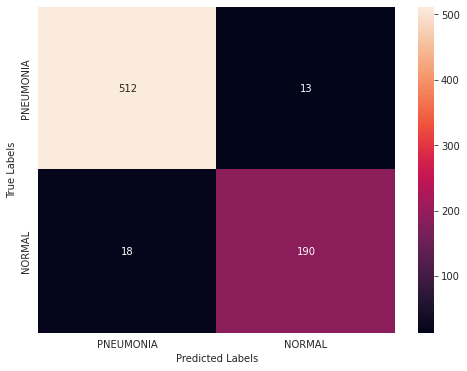

In [ ]:
# extract the predicted probabilities
p_pred = base.predict(X_test)
p_pred = p_pred.flatten()
y_pred = np.where(p_pred > 0.5, 1, 0)

base_predictions = base.predict(X_test)
cnf_plot(y_pred)

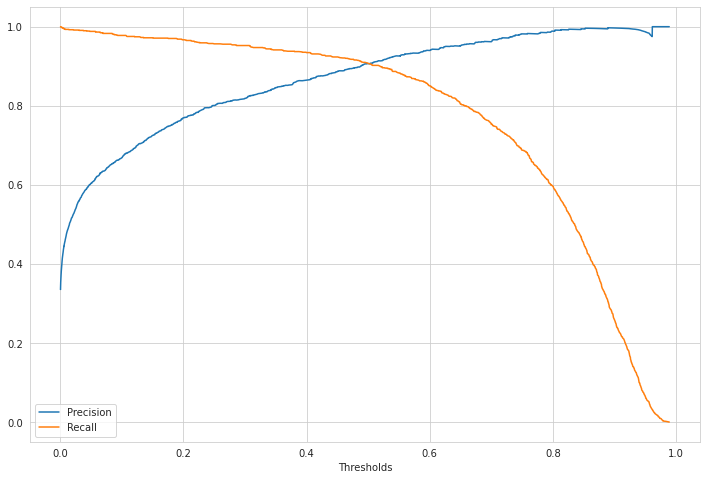

In [ ]:
cnn_pred = base.predict(X_train)
precisions, recalls, thresholds = precision_recall_curve(y_train, cnn_pred)
fpr, tpr, thresholds2 = roc_curve(y_train, cnn_pred)

plot_precision_recall(precisions, recalls, thresholds)

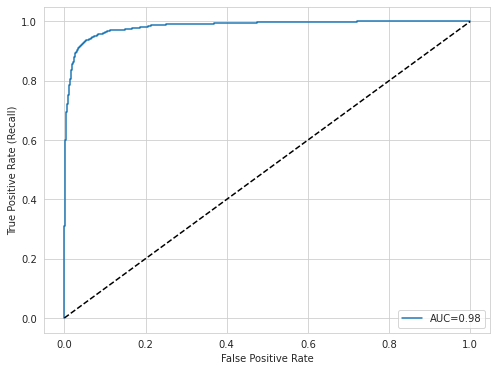

In [ ]:
area = np.round(auc(fpr,tpr),2)
plot_roc(fpr, tpr, area)

Building, Training and Evaluating the VGG16 Model

In [ ]:
def build_vgg_model(backbone, lr=lr):
    model = Sequential()
    model.add(backbone)
    model.add(Flatten())
    model.add(Dense(4096, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1000, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1,activation="sigmoid"))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer = SGD(lr=0.01),
        metrics=['acc']
    )
    return model

vgg16 = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(150,150,3) # the shape of the data
  )

In [ ]:
#building the model
vgg_model = build_vgg_model(vgg16,lr = lr)
vgg_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 4096)              33558528  
                                                                 
 dropout_5 (Dropout)         (None, 4096)              0         
                                                                 
 dense_5 (Dense)             (None, 4096)              16781312  
                                                                 
 dropout_6 (Dropout)         (None, 4096)              0         
                                                                 
 dense_6 (Dense)             (None, 1000)             

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
#Training the model
history = vgg_model.fit(train_datagen.flow(X_train, y_train),
                        batch_size = BATCH_SIZE, 
                        callbacks=[early_stop],
                        validation_data=(X_val, y_val), 
                        epochs=EPOCHS)

Epoch 1/100
138/138 [==============================] - 29s 189ms/step - loss: 0.5432 - acc: 0.7202 - val_loss: 0.5246 - val_acc: 0.7285
Epoch 2/100
138/138 [==============================] - 25s 178ms/step - loss: 0.4095 - acc: 0.7705 - val_loss: 0.2539 - val_acc: 0.9277
Epoch 3/100
138/138 [==============================] - 25s 178ms/step - loss: 0.3342 - acc: 0.8510 - val_loss: 0.2911 - val_acc: 0.8881
Epoch 4/100
138/138 [==============================] - 25s 181ms/step - loss: 0.3086 - acc: 0.8672 - val_loss: 0.1949 - val_acc: 0.9372
Epoch 5/100
138/138 [==============================] - 25s 179ms/step - loss: 0.2305 - acc: 0.9081 - val_loss: 0.2331 - val_acc: 0.9004
Epoch 6/100
138/138 [==============================] - 25s 178ms/step - loss: 0.1938 - acc: 0.9270 - val_loss: 0.1861 - val_acc: 0.9236
Epoch 7/100
138/138 [==============================] - 25s 178ms/step - loss: 0.1985 - acc: 0.9215 - val_loss: 0.1180 - val_acc: 0.9591
Epoch 8/100
138/138 [===========================

In [ ]:
#Evaluating the model
vgg_score = vgg_model.evaluate(X_test, y_test)

vgg_acc = np.round((vgg_score[1]*100),2)
print("Test Loss: ", vgg_score[0])
print("Test Accuracy: ", vgg_acc)

model_names.append("VGG16")
model_scores.append(vgg_acc)

23/23 [==============================] - 1s 43ms/step - loss: 0.0770 - acc: 0.9741
Test Loss:  0.07695198804140091
Test Accuracy:  97.41


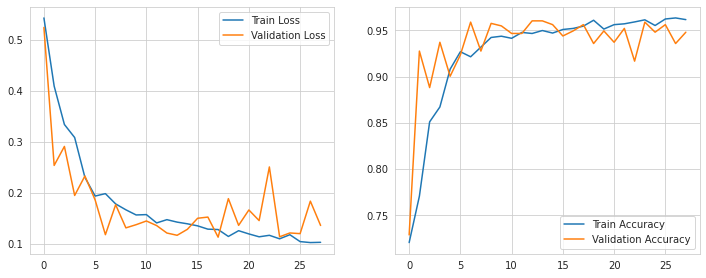

In [ ]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(history.history['acc'], label='Train Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.legend()

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       525
           1       0.93      0.98      0.96       208

    accuracy                           0.97       733
   macro avg       0.96      0.98      0.97       733
weighted avg       0.97      0.97      0.97       733

Sensitivity :  97.14
Specificity :  98.08


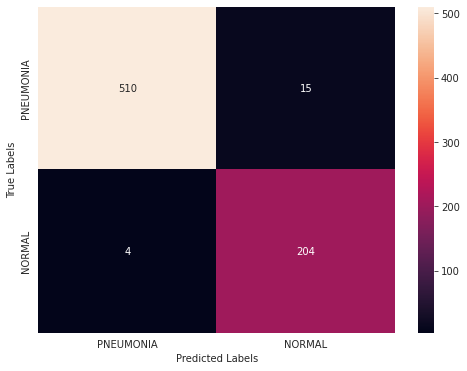

In [ ]:
p_pred = vgg_model.predict(X_test)
p_pred = p_pred.flatten()
y_pred = np.where(p_pred > 0.5, 1, 0)

vgg_predictions = vgg_model.predict(X_test)
cnf_plot(y_pred)

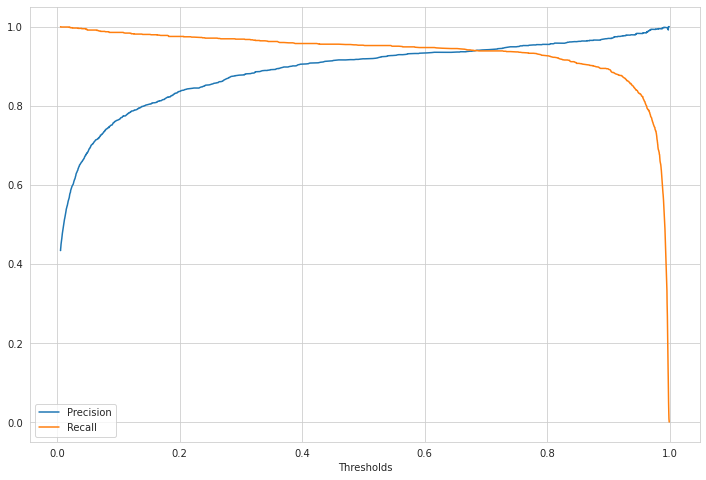

In [ ]:
vgg_pred = vgg_model.predict(X_train)
precisions, recalls, thresholds = precision_recall_curve(y_train, vgg_pred)
fpr, tpr, thresholds2 = roc_curve(y_train, vgg_pred)
plot_precision_recall(precisions, recalls, thresholds)

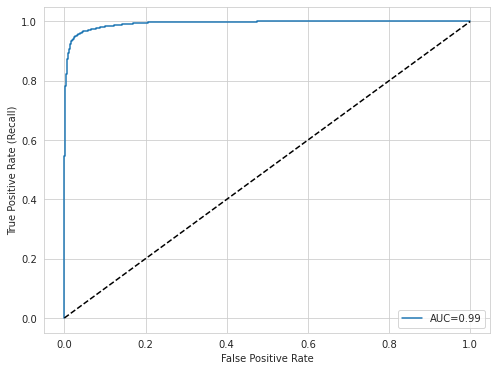

In [ ]:
area = np.round(auc(fpr,tpr),2)
plot_roc(fpr, tpr, area)

Building, Training and Evaluation of the ResNet50V2 Model

In [ ]:
# Implementing the ResNet50V2 model
def build_resnet_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(Flatten())
    model.add(Dense(4096, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1000, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1,activation="sigmoid"))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=adam,
        metrics=['acc']
    )
    return model

resnet50v2 = ResNet50V2(
    weights='imagenet',
    include_top=False,
    input_shape=(150,150,3) # the shape of the data
)

In [ ]:
resnet_model = build_resnet_model(resnet50v2, lr = lr)
resnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 5, 5, 2048)        23564800  
                                                                 
 flatten_2 (Flatten)         (None, 51200)             0         
                                                                 
 dense_8 (Dense)             (None, 4096)              209719296 
                                                                 
 dropout_8 (Dropout)         (None, 4096)              0         
                                                                 
 dense_9 (Dense)             (None, 4096)              16781312  
                                                                 
 dropout_9 (Dropout)         (None, 4096)              0         
                                                                 
 dense_10 (Dense)            (None, 1000)             

In [ ]:
#Training the model# Fit Model
history = resnet_model.fit(train_datagen.flow(X_train, y_train),
                           batch_size = BATCH_SIZE, 
                           callbacks=[early_stop], 
                           validation_data=(X_val, y_val), 
                           epochs=EPOCHS)

Epoch 1/100
138/138 [==============================] - 35s 200ms/step - loss: 0.5045 - acc: 0.8631 - val_loss: 0.8683 - val_acc: 0.8390
Epoch 2/100
138/138 [==============================] - 25s 182ms/step - loss: 0.2011 - acc: 0.9261 - val_loss: 0.1830 - val_acc: 0.9236
Epoch 3/100
138/138 [==============================] - 25s 182ms/step - loss: 0.1591 - acc: 0.9440 - val_loss: 0.1441 - val_acc: 0.9523
Epoch 4/100
138/138 [==============================] - 25s 179ms/step - loss: 0.2541 - acc: 0.9263 - val_loss: 0.2299 - val_acc: 0.9100
Epoch 5/100
138/138 [==============================] - 25s 181ms/step - loss: 0.2206 - acc: 0.9304 - val_loss: 0.6366 - val_acc: 0.9591
Epoch 6/100
138/138 [==============================] - 25s 178ms/step - loss: 0.1983 - acc: 0.9268 - val_loss: 0.2215 - val_acc: 0.9318
Epoch 7/100
138/138 [==============================] - 25s 179ms/step - loss: 0.3367 - acc: 0.9247 - val_loss: 0.6834 - val_acc: 0.7217
Epoch 8/100
138/138 [===========================

In [ ]:
# Evaluating the model
resnet_score = resnet_model.evaluate(X_test, y_test)

resnet_acc = np.round((resnet_score[1]*100),2)
print("Test Loss: ", resnet_score[0])
print("Test Accuracy: ", resnet_acc)

model_names.append("ResNet50V2")
model_scores.append(resnet_acc)

23/23 [==============================] - 1s 35ms/step - loss: 0.0615 - acc: 0.9741
Test Loss:  0.06154172495007515
Test Accuracy:  97.41


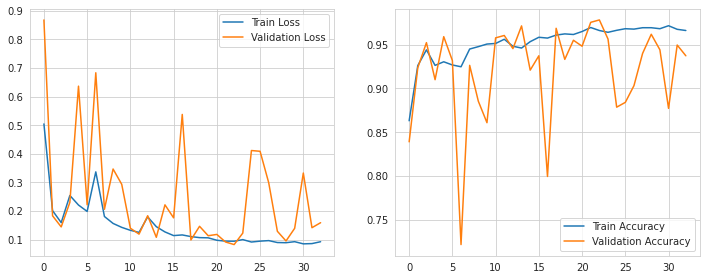

In [ ]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(history.history['acc'], label='Train Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.legend()

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       525
           1       0.95      0.96      0.95       208

    accuracy                           0.97       733
   macro avg       0.97      0.97      0.97       733
weighted avg       0.97      0.97      0.97       733

Sensitivity :  98.1
Specificity :  95.67


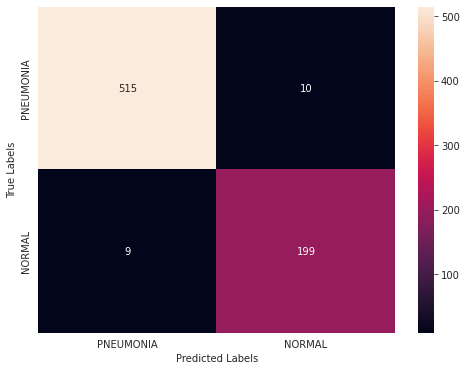

In [ ]:
p_pred = resnet_model.predict(X_test)
p_pred = p_pred.flatten()
y_pred = np.where(p_pred > 0.5, 1, 0)

resnet_predictions = resnet_model.predict(X_test)
cnf_plot(y_pred)

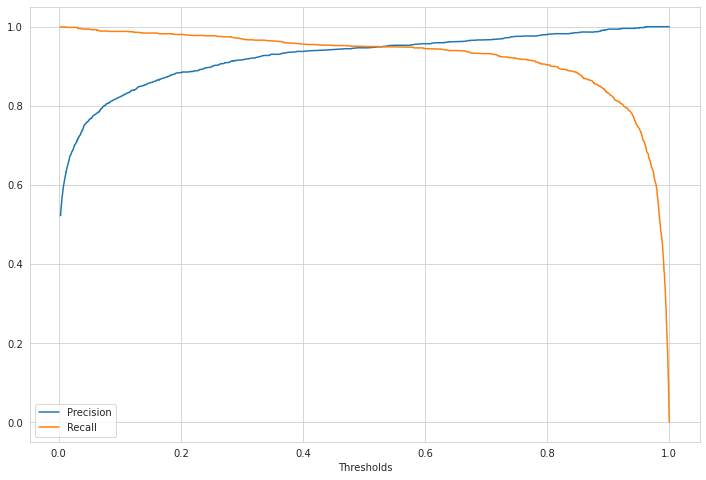

In [ ]:
resnet_pred = resnet_model.predict(X_train)
precisions, recalls, thresholds = precision_recall_curve(y_train, resnet_pred)
fpr, tpr, thresholds2 = roc_curve(y_train, resnet_pred)

plot_precision_recall(precisions, recalls, thresholds)

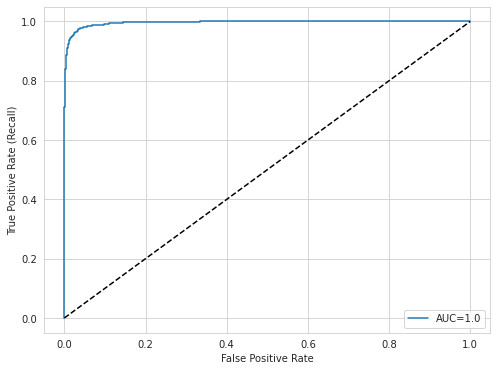

In [ ]:
area = np.round(auc(fpr,tpr),2)
plot_roc(fpr, tpr, area)

Results Comparison

In [ ]:
# Creating a dataframe to plot the results by first creating a dictionary
d = {'Models':model_names,'Scores':model_scores}

# The dataframe
df = pd.DataFrame(d)
df

,Models,Scores
0,CNN,95.77
1,VGG16,97.41
2,ResNet50V2,97.41


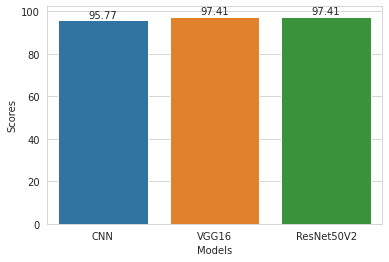

In [ ]:
# Displaying the model accuracies in a bar-plot

# create vertical barplot showing the results
p = sns.barplot(x="Models", y="Scores", data=df, ci=None)

#show values on barplot
show_values(p)

## System used for the Experiment

In [ ]:
# Hardware used for this experiment
!nvidia-smi

In [ ]:
!cat /proc/meminfo # checking the memory info